# Machine Learning Challenge

## Overview

The focus of this exercise is on a field within machine learning called [Natural Language Processing](https://en.wikipedia.org/wiki/Natural-language_processing). We can think of this field as the intersection between language, and machine learning. Tasks in this field include automatic translation (Google translate), intelligent personal assistants (Siri), information extraction, and speech recognition for example.

NLP uses many of the same techniques as traditional data science, but also features a number of specialised skills and approaches. There is no expectation that you have any experience with NLP, however, to complete the challenge it will be useful to have the following skills:

- understanding of the python programming language
- understanding of basic machine learning concepts, i.e. supervised learning


### Instructions

1. Download this notebook!
2. Answer each of the provided questions, including your source code as cells in this notebook.
3. Share the results with us, e.g. a Github repo.

### Task description

You will be performing a task known as [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis). Here, the goal is to predict sentiment -- the emotional intent behind a statement -- from text. For example, the sentence: "*This movie was terrible!"* has a negative sentiment, whereas "*loved this cinematic masterpiece*" has a positive sentiment.

To simplify the task, we consider sentiment binary: labels of `1` indicate a sentence has a positive sentiment, and labels of `0` indicate that the sentence has a negative sentiment.

### Dataset

The dataset is split across three files, representing three different sources -- Amazon, Yelp and IMDB. Your task is to build a sentiment analysis model using both the Yelp and IMDB data as your training-set, and test the performance of your model on the Amazon data.

Each file can be found in the `input` directory, and contains 1000 rows of data. Each row contains a sentence, a `tab` character and then a label -- `0` or `1`. 

**Notes**
- Feel free to use existing machine learning libraries as components in you solution!
- Suggested libraries: `sklearn` (for machine learning), `pandas` (for loading/processing data), `spacy` (for text processing).
- As mentioned, you are not expected to have previous experience with this exact task. You are free to refer to external tutorials/resources to assist you. However, you will be asked to justfify the choices you have made -- so make you understand the approach you have taken.

In [1]:
import os
print(os.listdir("./input"))

['amazon_cells_labelled.txt', 'imdb_labelled.txt', 'yelp_labelled.txt']


# Tasks
### 1. Read and concatenate data into test and train sets.

Combine all review data into two Pandas Data Frames representing the train and test datasets

In [2]:
import pandas as pd

# Set path to the data files
path = './input/'

# Add column names
col_names = ['Text', 'Label']

# Import data files as Pandas Dataframes
df_yelp = pd.read_table(path+'yelp_labelled.txt', names=col_names)
df_amazon = pd.read_table(path+'amazon_cells_labelled.txt', names=col_names) # Use as test dataset
df_imdb = pd.read_table(path+'imdb_labelled.txt', names=col_names)

# Combine/union Yelp and IMDB into a single dataframe
df_comb = pd.concat([df_yelp, df_imdb])    # Use as train data set


In [3]:
# Combine all three datasets into one and use for alternative testing

df_all = pd.concat([df_yelp, df_imdb, df_amazon])

### 2. Prepare the data for input into your model.

In [4]:
# Checking for Missing Values
df_all.isnull().sum()

Text     0
Label    0
dtype: int64

**Lemmatize and remove stop words from the obtained dataset.**

**Tokenization** is the process of breaking text into pieces, called tokens, and ignoring characters like punctuation marks (,. “ ‘) and spaces. spaCy‘s tokenizer takes input in form of unicode text and outputs a sequence of token objects.

In [5]:
from  spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

# Build a list of stopwords to use to filter
stopwords = list(STOP_WORDS)


nlp = en_core_web_sm.load()

import string
punctuations = string.punctuation

def my_tokenizer(sentence):
    mytokens = nlp(sentence)
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    return mytokens

In [6]:
type(nlp("This is how John Walker was walking. He was also running beside the lawn."))

spacy.tokens.doc.Doc

In [7]:
# Example of tekonizer
my_tokenizer("This is how John Walker was walking. He was also running beside the lawn.")

['john', 'walker', 'walk', 'run', 'lawn']

In [8]:
# Import required ML Packages
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score 
from sklearn.base import TransformerMixin 


# Basic text cleaning function that removes spaces and converts text into lowercase
def clean_text(text):     
    return text.strip().lower()

#Custom transformer that inherits from the TransformerMixin class
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}
    
# Bag of Words (BoW) converts text into the matrix of occurrence of words within a given document
# Convert a collection of text documents to a matrix of token counts
# This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.
vectorizer = CountVectorizer(tokenizer = my_tokenizer, ngram_range=(1,1)) 

In [9]:
# Select Train and Test datasets and split into text and labels
X_train = df_comb['Text']
y_train = df_comb['Label']

X_test = df_amazon['Text']
y_test = df_amazon['Label']

#### 2a: Find the ten most frequent words in the training set.

In [10]:
df_comb['Tokenised Text'] = df_comb['Text'].apply(lambda x: my_tokenizer(x)).apply(lambda x: ' '.join(x))

df_comb.head()

,Text,Label,Tokenised Text
0,Wow... Loved this place.,1,wow ... love place
1,Crust is not good.,0,crust good
2,Not tasty and the texture was just nasty.,0,tasty texture nasty
3,Stopped by during the late May bank holiday of...,1,stop late bank holiday rick steve recommendati...
4,The selection on the menu was great and so wer...,1,selection menu great price


In [11]:
#List top 10 most frequent words from the training set
words = pd.Series(' '.join(df_comb['Tokenised Text']).split()).value_counts()[:10]

words

movie    212
good     201
film     189
0        138
food     127
bad      126
1        124
place    119
great    115
like     111
dtype: int64

### 3. Train your model and justify your choices.

In [12]:
from sklearn.svm import LinearSVC


# Select Linear Support Vector Classification 
classifier = LinearSVC()

In [13]:
%%time
from sklearn.pipeline import Pipeline

# Create a pipeline with three components: a cleaner, a vectorizer, and a classifier. 
# The cleaner uses our predictors class object to clean and preprocess the text. 
# The vectorizer uses countvector objects to create the bag of words matrix for our text. 
# The classifier is an object that performs the logistic regression to classify the sentiments
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])

# Fit our data - Fit the model according to the given training data.
pipe.fit(X_train,y_train)


# Predicting with a test dataset - Predict class labels for samples in X.
# sample_prediction = pipe_countvect.predict(X_test)

# Print Prediction Results
# 1 = Positive review
# 0 = Negative review
# for (sample,pred) in zip(X_test,sample_prediction):
#     print(sample,"Prediction=>",pred)



Wall time: 14.6 s


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x00000207A215C040>),
                ('vectorizer',
                 CountVectorizer(tokenizer=<function my_tokenizer at 0x000002079AD6F550>)),
                ('classifier', LinearSVC())])

### 4. Evaluate your model using metric(s) you see fit and justify your choices.

In [14]:
import numpy as np
# Results - Accuracy - Balanced Problem
#Return the mean accuracy on the given test data and labels.

print("LinearSVC Training Accuracy: ", np.around(pipe.score(X_train, y_train), decimals=3))
print("LinearSVC Test Accuracy: ", np.around(pipe.score(X_test, y_test), decimals=3))

LinearSVC Training Accuracy:  0.986
LinearSVC Test Accuracy:  0.75


### Additional Notes on Accuracy:

Informally, accuracy is the fraction of predictions our model got right. Accuracy alone doesn't tell the full story when you're working with a class-imbalanced data set, where there is a significant disparity between the number of positive and negative labels.

To fully evaluate the effectiveness of a model, you must examine both **precision** and **recall**.

![Accuracy - Precision](./images/precision.png "Title")
![Accuracy - Recall](./images/recall.png "Title")

In [15]:
from sklearn import metrics

# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Support Vector Classification Accuracy:", np.around(metrics.accuracy_score(y_test, predicted), decimals=3))
print("Support Vector Classification Precision:", np.around(metrics.precision_score(y_test, predicted), decimals=3))
print("Support Vector Classification Recall:", np.around(metrics.recall_score(y_test, predicted), decimals=3))

Support Vector Classification Accuracy: 0.75
Support Vector Classification Precision: 0.805
Support Vector Classification Recall: 0.66


In [16]:
%%time

# Prediction model using LogisticRegression
from sklearn.linear_model import LogisticRegression


pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', LogisticRegression())])

# Fit our data - Fit the model according to the given training data.
pipe.fit(X_train,y_train)

# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:", np.around(metrics.accuracy_score(y_test, predicted), decimals=3))
print("Logistic Regression Precision:", np.around(metrics.precision_score(y_test, predicted), decimals=3))
print("Logistic Regression Recall:", np.around(metrics.recall_score(y_test, predicted), decimals=3))

Logistic Regression Accuracy: 0.772
Logistic Regression Precision: 0.845
Logistic Regression Recall: 0.666
Wall time: 25.5 s


### 5. Evaluate alternative train/test model using all datasets combined and using 80-20 split

#### 5.1 Splitting data into Train and Test sets

In [17]:
# Splitting Data Set
from sklearn.model_selection import train_test_split

# Features and Labels
X = df_all['Text']
ylabels = df_all['Label']

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=42)

In [18]:
# Create a dataframe for recording the model performance
df_performance = pd.DataFrame(columns=('Model', 'Train Accuracy', 'Test Accuracy', 'Test Precision', 'Test Recall'))

#### 5.2 Applying different classification models to test performance

#### 5.2.1 Linear Support Vector Classification 

In [19]:
%%time

# Prediction model using LinearSVC
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', LinearSVC())])

# Fit our data
pipe.fit(X_train,y_train)

# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Record performance
perf_record = [{'Model': 'LinearSVC', 
         'Train Accuracy': np.around(pipe.score(X_train,y_train), decimals=3),
         'Test Accuracy': np.around(metrics.accuracy_score(y_test, predicted), decimals=3),
        'Test Precision': np.around(metrics.precision_score(y_test, predicted), decimals=3), 
         'Test Recall': np.around(metrics.recall_score(y_test, predicted), decimals=3)}]

df_performance = df_performance.append(perf_record, ignore_index=True, sort=False)

# Model Accuracy
print("LinearSVC Training Accuracy:", np.around(pipe.score(X_train,y_train), decimals=3))
print("LinearSVC Test Accuracy:", np.around(metrics.accuracy_score(y_test, predicted), decimals=3))
print("LinearSVC Test Precision:", np.around(metrics.precision_score(y_test, predicted), decimals=3))
print("LinearSVC Test Recall:", np.around(metrics.recall_score(y_test, predicted), decimals=3))

LinearSVC Training Accuracy: 0.976
LinearSVC Test Accuracy: 0.767
LinearSVC Test Precision: 0.733
LinearSVC Test Recall: 0.774
Wall time: 1min 4s


#### 5.2.2 Logistic Regression

In [20]:
%%time
# Prediction model using LogisticRegression

pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', LogisticRegression())])

# Fit our data - Fit the model according to the given training data.
pipe.fit(X_train,y_train)

# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Record performance
perf_record = [{'Model': 'LogisticRegression', 
         'Train Accuracy': np.around(pipe.score(X_train,y_train), decimals=3),
         'Test Accuracy': np.around(metrics.accuracy_score(y_test, predicted), decimals=3),
        'Test Precision': np.around(metrics.precision_score(y_test, predicted), decimals=3), 
         'Test Recall': np.around(metrics.recall_score(y_test, predicted), decimals=3)}]

df_performance = df_performance.append(perf_record, ignore_index=True, sort=False)

# Model Accuracy
print("Logistic Regression Training Accuracy:", np.around(pipe.score(X_train,y_train), decimals=3))
print("Logistic Regression Accuracy:", np.around(metrics.accuracy_score(y_test, predicted), decimals=3))
print("Logistic Regression Precision:", np.around(metrics.precision_score(y_test, predicted), decimals=3))
print("Logistic Regression Recall:", np.around(metrics.recall_score(y_test, predicted), decimals=3))

Logistic Regression Training Accuracy: 0.946
Logistic Regression Accuracy: 0.78
Logistic Regression Precision: 0.755
Logistic Regression Recall: 0.77
Wall time: 59.6 s


#### 5.2.3 Decision Tree Classifier

In [21]:
%%time
# Prediction model using DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', DecisionTreeClassifier(random_state=0, min_samples_split = 150))])

# Fit our data - Fit the model according to the given training data.
pipe.fit(X_train,y_train)

# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Record performance
perf_record = [{'Model': 'DecisionTreeClassifier', 
         'Train Accuracy': np.around(pipe.score(X_train,y_train), decimals=3),
         'Test Accuracy': np.around(metrics.accuracy_score(y_test, predicted), decimals=3),
        'Test Precision': np.around(metrics.precision_score(y_test, predicted), decimals=3), 
         'Test Recall': np.around(metrics.recall_score(y_test, predicted), decimals=3)}]

df_performance = df_performance.append(perf_record, ignore_index=True, sort=False)

# Model Accuracy
print("DecisionTreeClassifier Training Accuracy:", np.around(pipe.score(X_train,y_train), decimals=3))
print("DecisionTreeClassifier Accuracy:", np.around(metrics.accuracy_score(y_test, predicted), decimals=3))
print("DecisionTreeClassifier Precision:", np.around(metrics.precision_score(y_test, predicted), decimals=3))
print("DecisionTreeClassifier Recall:", np.around(metrics.recall_score(y_test, predicted), decimals=3))

DecisionTreeClassifier Training Accuracy: 0.907
DecisionTreeClassifier Accuracy: 0.736
DecisionTreeClassifier Precision: 0.711
DecisionTreeClassifier Recall: 0.714
Wall time: 58 s


#### 5.2.4 Random Forest Classifier

In [22]:
%%time
# Prediction model using RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', RandomForestClassifier(n_estimators=100,oob_score=True))])

# Fit our data - Fit the model according to the given training data.
pipe.fit(X_train,y_train)

# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Record performance
perf_record = [{'Model': 'RandomForestClassifier', 
         'Train Accuracy': np.around(pipe.score(X_train,y_train), decimals=3),
         'Test Accuracy': np.around(metrics.accuracy_score(y_test, predicted), decimals=3),
        'Test Precision': np.around(metrics.precision_score(y_test, predicted), decimals=3), 
         'Test Recall': np.around(metrics.recall_score(y_test, predicted), decimals=3)}]

df_performance = df_performance.append(perf_record, ignore_index=True, sort=False)

# Model Accuracy
print("RandomForestClassifier Training Accuracy:", np.around(pipe.score(X_train,y_train), decimals=3))
print("RandomForestClassifier Accuracy:", np.around(metrics.accuracy_score(y_test, predicted), decimals=3))
print("RandomForestClassifier Precision:", np.around(metrics.precision_score(y_test, predicted), decimals=3))
print("RandomForestClassifier Recall:", np.around(metrics.recall_score(y_test, predicted), decimals=3))

RandomForestClassifier Training Accuracy: 0.993
RandomForestClassifier Accuracy: 0.733
RandomForestClassifier Precision: 0.708
RandomForestClassifier Recall: 0.71
Wall time: 1min 2s


In [23]:
df_performance

,Model,Train Accuracy,Test Accuracy,Test Precision,Test Recall
0,LinearSVC,0.976,0.767,0.733,0.774
1,LogisticRegression,0.946,0.780,0.755,0.770
2,DecisionTreeClassifier,0.907,0.736,0.711,0.714
3,RandomForestClassifier,0.993,0.733,0.708,0.710


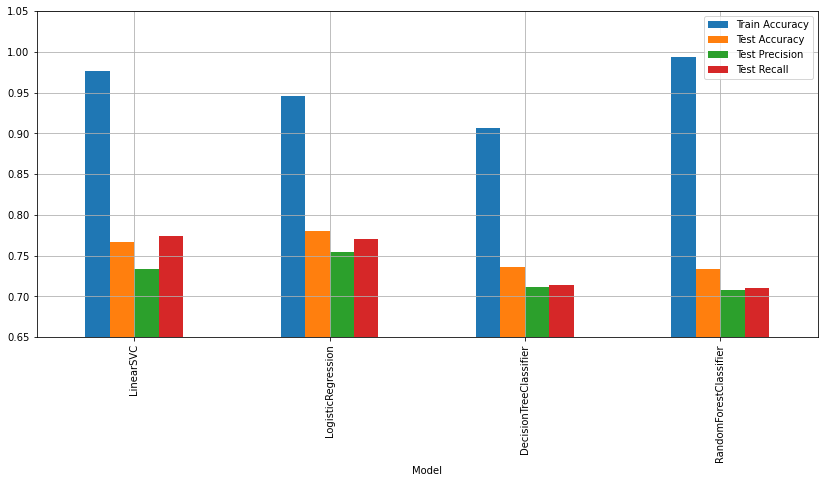

In [24]:
# Plot the results of different models
df_performance.plot(kind='bar', grid='on', x = 'Model', figsize = (14,6), ylim=(0.65,1.05),);